In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

During the 2020 NFL season, due to covid, we had the unique oppurtunity to see what NFL games are like with no fans. Many players talked about how different the atmosphere was during games, and how it felt like a "highschool scrimage". Fans are often told how much they impact them game, and as a fan myself the idea that you have such an impact is a pretty awesome idea. So i wanted to look deeper into the impact fans.

This will be pretty difficult to answer as a single season isnt a huge sample size, but i doubt we will ever see an NFL game without fans again. With how often gameplans change i will only be using recent NFL seasons to try and limit this variation.

Hypothesis
1. With the lack of crowd noise i believe that offenses will be able to communicate better, increasing total yards
2. Offensive lines be better prepared for the snap leading to less penalties and sacks allowed
3. away teams will have a larger winning percentage without a crowd
4. teams will be more willing to go for it on 4th down

In [161]:
df = pd.read_csv("./data_sets/nfl_team_stats_2002-2022.csv")
pd.set_option('display.max_columns', 70)
sns.set_style("white")

In [162]:
cols_to_split = [
{
    "name": "third_downs",
    "first_split": "third_down_conv",
    "second_split": "third_down_attempt"
},
{
    "name": "fourth_downs",
    "first_split": "fourth_down_conv",
    "second_split": "fourth_down_attempt"
},
{
    "name": "sacks",
    "first_split": "sacks",
    "second_split": "sack_yards"
},
{
    "name": "comp_att",
    "first_split": "pass_comp",
    "second_split": "pass_attempt"
},
{
    "name": "penalties",
    "first_split": "penalties",
    "second_split": "penalty_yards"
},
{
    "name": "redzone",
    "first_split": "redzone_conv",
    "second_split": "redzone_attempt"
},
]

def split_col(col, df):
    name = col['name']
    first_split = col['first_split']
    second_split = col['second_split']

    split = df[name].str.split("-", expand = True)
    df = df.drop(name, axis=1)
    df[first_split] = split[0].astype(int)
    df[second_split] = split[1].astype(int)
    return df

In [163]:
df['date']= pd.to_datetime(df['date'])

#NFL season goes into next year so include janurary and february games in with previous year
df['year'] = np.where(df['date'].dt.month > 2 , df['date'].dt.year, df['date'].dt.year - 1)

df['won'] = np.where(df['score_away'] < df['score_home'], "home", "away")

#Kickoff moved up to 35 yard line in 2011 so i am only including data used from then on
df = df[df['year'] >= 2011]

#splitting original df into home and away
away_cols = df.columns[df.columns.str.contains("away")]
home_cols = df.columns[df.columns.str.contains("home")]

away_df = df.drop(home_cols, axis=1)
home_df = df.drop(away_cols, axis=1)

away_df.rename(columns={'away': 'team'}, inplace=True)
home_df.rename(columns={'home': 'team'}, inplace=True)

away_df['des'] = 'away'
away_df['won'] = df['won'] == 'away'

home_df['des'] = 'home'
home_df['won'] = df['won'] == 'home'

away_df.columns = away_df.columns.str.replace("_away", "")
home_df.columns = home_df.columns.str.replace("_home", "")

for col in cols_to_split:
   away_df = split_col(col, away_df)
   home_df = split_col(col, home_df)

home_away_df = pd.concat([home_df, away_df]).reset_index(drop=True)

yearly_df = home_away_df.drop(columns=["date", "possession"]).groupby(["year", "team", "des"]).mean().reset_index()

yearly_df.head()

,year,team,des,first_downs,passing_yards,rushing_yards,total_yards,rushing_attempts,fumbles,int,turnovers,drives,def_st_td,score,won,third_down_conv,third_down_attempt,fourth_down_conv,fourth_down_attempt,sacks,sack_yards,pass_comp,pass_attempt,penalties,penalty_yards,redzone_conv,redzone_attempt
0,2011,49ers,away,16.625,171.000000,126.625000,297.625000,29.250000,0.500000,0.250000,0.750000,13.000000,0.000000,19.875,0.750000,3.625000,14.000000,0.750000,1.250000,3.875000,21.250,17.875000,29.625000,8.000000,71.750000,1.125000,2.500000
1,2011,49ers,home,18.100,200.400000,132.400000,332.800000,31.400000,0.400000,0.300000,0.700000,12.300000,0.400000,27.400,0.800000,4.100000,13.700000,0.300000,0.400000,2.000000,14.600,17.000000,28.200000,5.800000,52.300000,1.700000,4.100000
2,2011,Bears,away,18.250,190.375000,143.125000,333.500000,29.500000,0.750000,1.000000,1.750000,12.750000,0.375000,18.500,0.375000,4.500000,13.250000,0.000000,0.250000,3.250000,21.875,18.250000,31.875000,7.250000,54.500000,1.250000,2.125000
3,2011,Bears,home,15.625,186.000000,108.750000,294.750000,27.500000,0.375000,1.500000,1.875000,12.750000,1.625000,25.625,0.625000,3.750000,12.125000,0.250000,0.750000,2.875000,20.000,15.250000,27.250000,5.750000,45.500000,1.250000,2.750000
4,2011,Bengals,away,18.000,209.555556,99.777778,309.333333,27.333333,0.111111,1.222222,1.333333,12.777778,0.555556,22.000,0.555556,5.111111,14.111111,0.333333,1.111111,2.222222,16.000,20.333333,34.777778,6.666667,61.555556,1.777778,3.111111


In [164]:
yearly_df.shape

(768, 27)

In [165]:
yearly_df.dtypes

year                     int32
team                    object
des                     object
first_downs            float64
passing_yards          float64
rushing_yards          float64
total_yards            float64
rushing_attempts       float64
fumbles                float64
int                    float64
turnovers              float64
drives                 float64
def_st_td              float64
score                  float64
won                    float64
third_down_conv        float64
third_down_attempt     float64
fourth_down_conv       float64
fourth_down_attempt    float64
sacks                  float64
sack_yards             float64
pass_comp              float64
pass_attempt           float64
penalties              float64
penalty_yards          float64
redzone_conv           float64
redzone_attempt        float64
dtype: object

In [166]:
yearly_df.columns

Index(['year', 'team', 'des', 'first_downs', 'passing_yards', 'rushing_yards',
       'total_yards', 'rushing_attempts', 'fumbles', 'int', 'turnovers',
       'drives', 'def_st_td', 'score', 'won', 'third_down_conv',
       'third_down_attempt', 'fourth_down_conv', 'fourth_down_attempt',
       'sacks', 'sack_yards', 'pass_comp', 'pass_attempt', 'penalties',
       'penalty_yards', 'redzone_conv', 'redzone_attempt'],
      dtype='object')

In [167]:
yearly_df.isna().sum()

year                   0
team                   0
des                    0
first_downs            0
passing_yards          0
rushing_yards          0
total_yards            0
rushing_attempts       0
fumbles                0
int                    0
turnovers              0
drives                 0
def_st_td              0
score                  0
won                    0
third_down_conv        0
third_down_attempt     0
fourth_down_conv       0
fourth_down_attempt    0
sacks                  0
sack_yards             0
pass_comp              0
pass_attempt           0
penalties              0
penalty_yards          0
redzone_conv           0
redzone_attempt        0
dtype: int64

In [168]:
yearly_df.describe()

,year,first_downs,passing_yards,rushing_yards,total_yards,rushing_attempts,fumbles,int,turnovers,drives,def_st_td,score,won,third_down_conv,third_down_attempt,fourth_down_conv,fourth_down_attempt,sacks,sack_yards,pass_comp,pass_attempt,penalties,penalty_yards,redzone_conv,redzone_attempt
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,2016.500000,20.082493,233.502826,113.594538,347.097365,26.633384,0.569460,0.857377,1.426837,11.475238,0.289832,22.725497,0.492217,5.139322,13.104025,0.534124,1.065807,2.360205,15.565419,21.884664,34.816754,6.325014,53.840634,1.635961,2.911652
std,3.454302,2.489619,40.527607,23.951186,40.817248,3.522575,0.268903,0.368552,0.474230,0.805654,0.279450,4.948651,0.221777,0.866038,1.039755,0.309844,0.471753,0.747770,5.351931,3.232609,4.259597,1.185748,11.171825,0.724783,1.077620
min,2011.000000,13.250000,121.125000,55.750000,225.000000,18.750000,0.000000,0.111111,0.250000,9.375000,0.000000,8.125000,0.000000,2.625000,10.250000,0.000000,0.111111,0.625000,4.500000,12.375000,20.750000,3.250000,22.875000,0.000000,0.000000
25%,2013.750000,18.427083,205.416667,96.222222,318.822917,24.181250,0.375000,0.625000,1.111111,10.888889,0.000000,19.250000,0.375000,4.500000,12.375000,0.325000,0.750000,1.875000,11.875000,19.625000,32.243056,5.500000,46.000000,1.250000,2.625000
50%,2016.500000,20.100000,230.812500,111.316667,346.173611,26.173611,0.500000,0.825758,1.375000,11.500000,0.250000,22.354167,0.500000,5.125000,13.111111,0.500000,1.000000,2.250000,14.888889,21.777778,34.750000,6.250000,52.777778,1.666667,3.118056
75%,2019.250000,21.666667,260.420139,128.750000,373.027778,29.090278,0.750000,1.125000,1.750000,12.000000,0.500000,25.750000,0.625000,5.703571,13.800000,0.750000,1.375000,2.875000,18.875000,24.000000,37.500000,7.102778,60.750000,2.111111,3.566667
max,2022.000000,27.700000,351.888889,210.444444,507.444444,39.000000,1.714286,3.000000,3.875000,13.888889,1.875000,41.555556,1.000000,8.125000,16.500000,1.750000,2.625000,5.125000,38.750000,32.444444,49.000000,11.222222,99.500000,3.666667,5.333333


In [169]:
yearly_df.head()

,year,team,des,first_downs,passing_yards,rushing_yards,total_yards,rushing_attempts,fumbles,int,turnovers,drives,def_st_td,score,won,third_down_conv,third_down_attempt,fourth_down_conv,fourth_down_attempt,sacks,sack_yards,pass_comp,pass_attempt,penalties,penalty_yards,redzone_conv,redzone_attempt
0,2011,49ers,away,16.625,171.000000,126.625000,297.625000,29.250000,0.500000,0.250000,0.750000,13.000000,0.000000,19.875,0.750000,3.625000,14.000000,0.750000,1.250000,3.875000,21.250,17.875000,29.625000,8.000000,71.750000,1.125000,2.500000
1,2011,49ers,home,18.100,200.400000,132.400000,332.800000,31.400000,0.400000,0.300000,0.700000,12.300000,0.400000,27.400,0.800000,4.100000,13.700000,0.300000,0.400000,2.000000,14.600,17.000000,28.200000,5.800000,52.300000,1.700000,4.100000
2,2011,Bears,away,18.250,190.375000,143.125000,333.500000,29.500000,0.750000,1.000000,1.750000,12.750000,0.375000,18.500,0.375000,4.500000,13.250000,0.000000,0.250000,3.250000,21.875,18.250000,31.875000,7.250000,54.500000,1.250000,2.125000
3,2011,Bears,home,15.625,186.000000,108.750000,294.750000,27.500000,0.375000,1.500000,1.875000,12.750000,1.625000,25.625,0.625000,3.750000,12.125000,0.250000,0.750000,2.875000,20.000,15.250000,27.250000,5.750000,45.500000,1.250000,2.750000
4,2011,Bengals,away,18.000,209.555556,99.777778,309.333333,27.333333,0.111111,1.222222,1.333333,12.777778,0.555556,22.000,0.555556,5.111111,14.111111,0.333333,1.111111,2.222222,16.000,20.333333,34.777778,6.666667,61.555556,1.777778,3.111111


c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


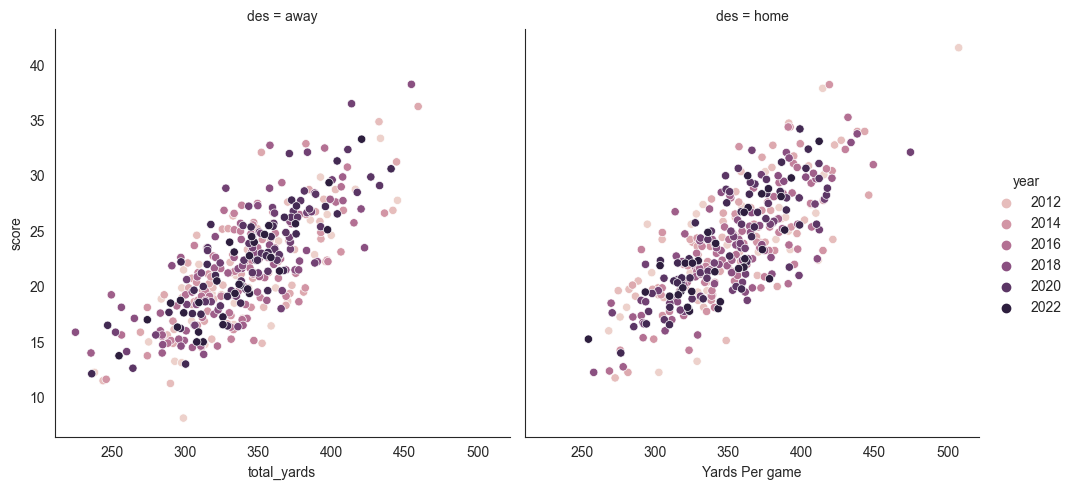

In [170]:
sns.relplot(
    yearly_df, x="total_yards", y="score",
    col="des", hue="year",
    kind="scatter"
)
plt.xlabel("Yards Per game")
plt.ylabel("Points per game")
plt.show()


univarate Graphics

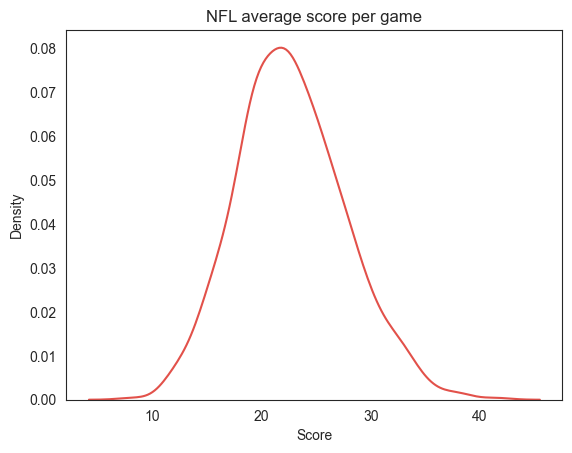

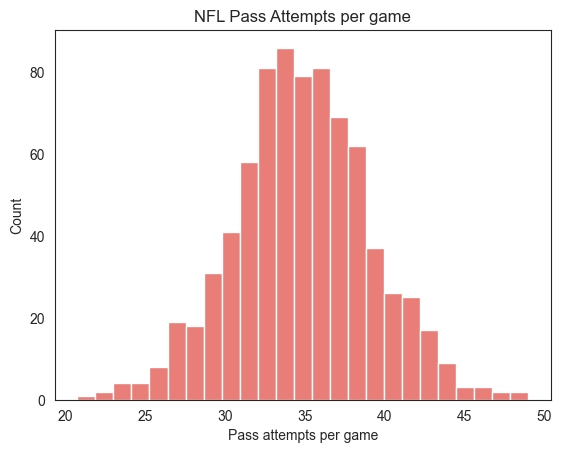

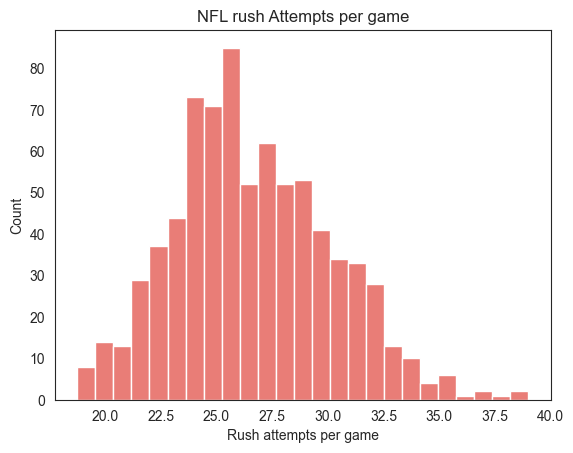

In [171]:
sns.kdeplot(yearly_df, x="score")
plt.xlabel("Score")
plt.title("NFL average score per game")
plt.show()

sns.histplot(yearly_df, x="pass_attempt", bins=25)
plt.xlabel("Pass attempts per game")
plt.title("NFL Pass Attempts per game")
plt.show()

sns.histplot(yearly_df, x="rushing_attempts", bins=25)
plt.xlabel("Rush attempts per game")
plt.title("NFL rush Attempts per game")
plt.show()




Yard and score changes over years

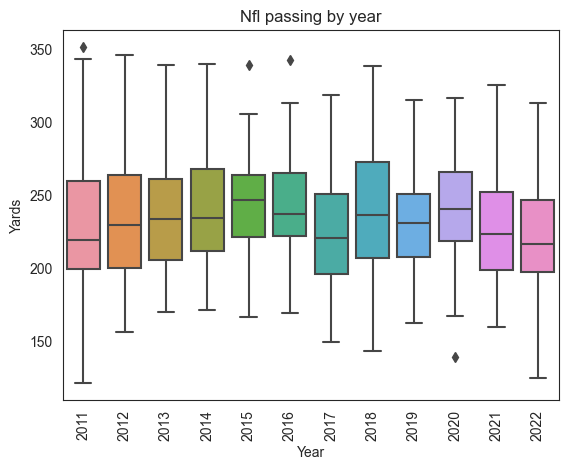

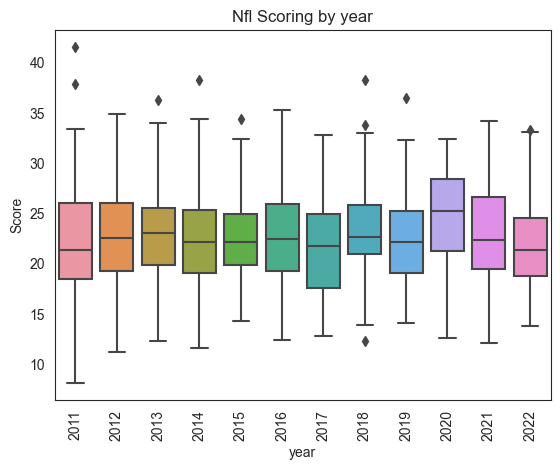

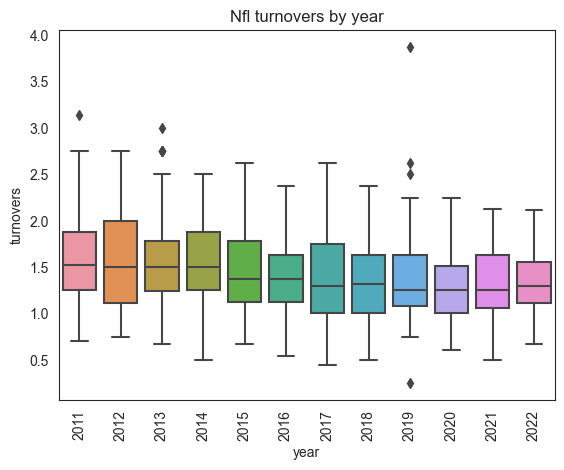

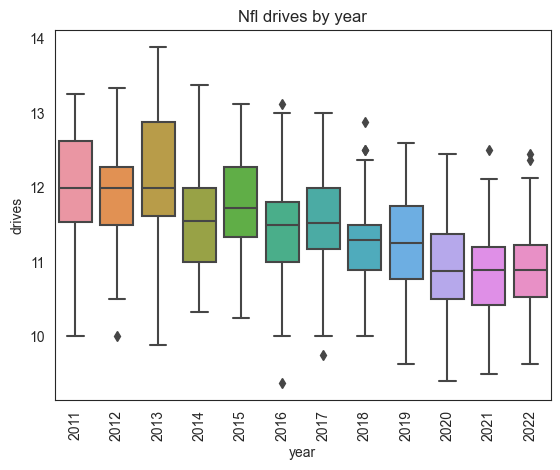

In [172]:
sns.boxplot(yearly_df, x="year", y="passing_yards")
plt.xticks(rotation="vertical")
plt.xlabel("Year")
plt.ylabel("Yards")
plt.title("Nfl passing by year")
plt.show()

sns.boxplot(yearly_df, x="year", y="score")
plt.xticks(rotation="vertical")
plt.ylabel("Score")
plt.title("Nfl Scoring by year")
plt.show()

sns.boxplot(yearly_df, x="year", y="turnovers")
plt.xticks(rotation="vertical")
plt.ylabel("turnovers")
plt.title("Nfl turnovers by year")
plt.show()

sns.boxplot(yearly_df, x="year", y="drives")
plt.xticks(rotation="vertical")
plt.ylabel("drives")
plt.title("Nfl drives by year")
plt.show()

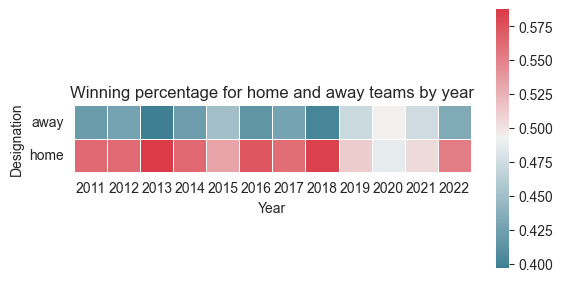

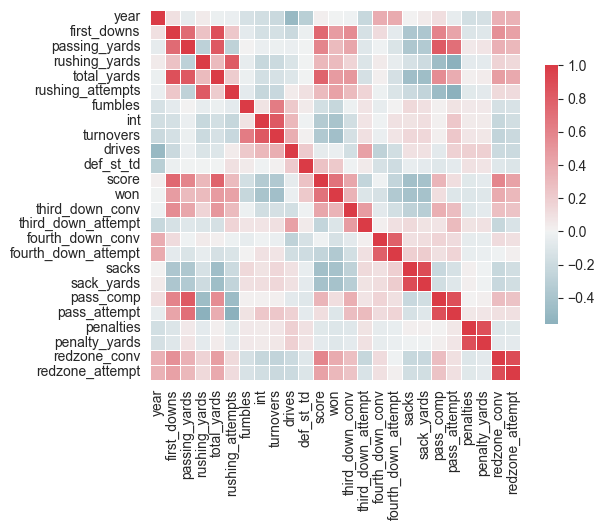

In [173]:
grouped = yearly_df.groupby(['year', "des"]).mean(numeric_only=True).reset_index()

pivot = grouped.pivot(index="des", columns="year", values="won")

vmax=grouped["won"].max()
vmin=grouped["won"].min()

cmap = sns.diverging_palette(220, 10, as_cmap=True) 

ax =sns.heatmap(pivot, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .7},  vmax=vmax, vmin=vmin) 
plt.title("Winning percentage for home and away teams by year")
plt.ylabel("Designation")
plt.xlabel("Year")
plt.show()

corr = yearly_df.corr(numeric_only=True)
ax =sns.heatmap(corr, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7}) 
plt.show()

Home and Away Comparison

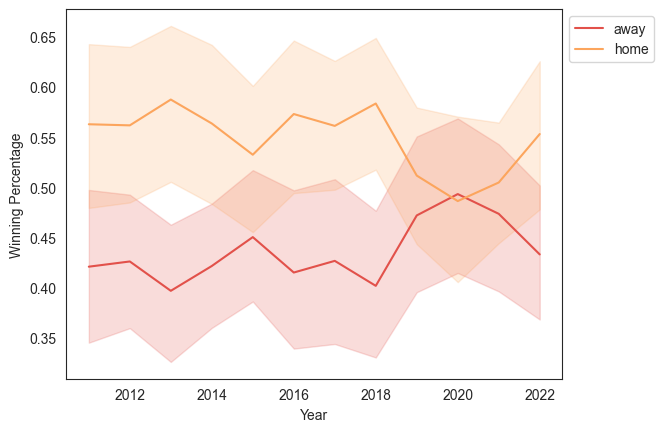

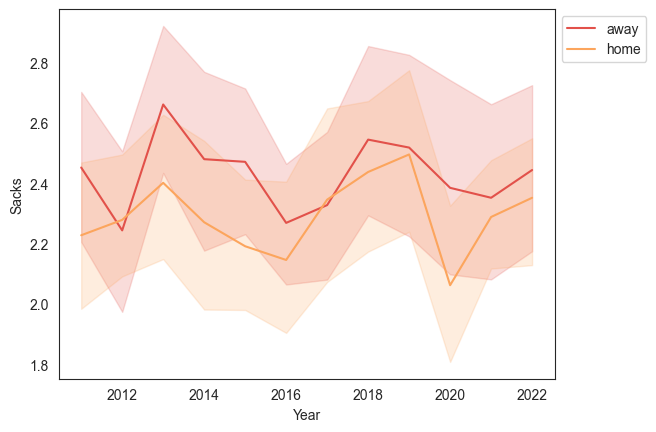

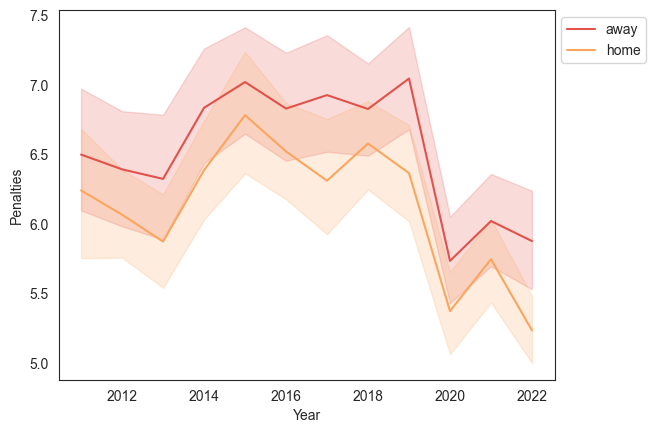

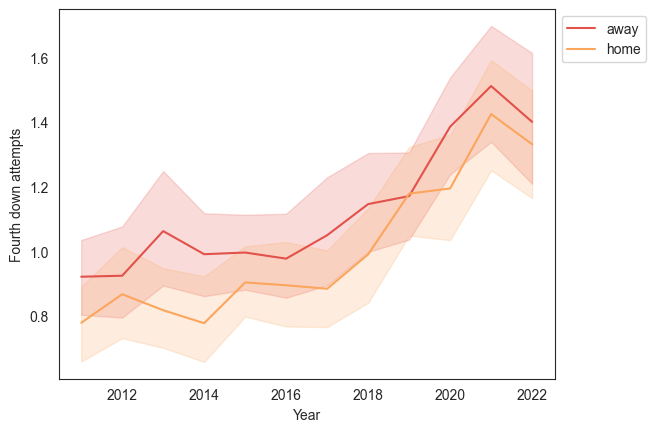

In [174]:
sns.lineplot(yearly_df, x="year", y="won", hue="des")

plt.xlabel("Year")
plt.ylabel("Winning Percentage")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

sns.lineplot(yearly_df, x="year", y="sacks", hue="des")

plt.xlabel("Year")
plt.ylabel("Sacks")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

sns.lineplot(yearly_df, x="year", y="penalties", hue="des")

plt.xlabel("Year")
plt.ylabel("Penalties")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

sns.lineplot(yearly_df, x="year", y="fourth_down_attempt", hue="des")

plt.xlabel("Year")
plt.ylabel("Fourth down attempts")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()